In [1]:
import  numpy as np
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import random

# Helper funcs related to model

In [2]:
def tied_data_gen_wrapper(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt):
    """
    A wrapper to run the simulation in parallel
    """
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    choice, rt = simulated_tied_ddm_norm(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt)
    return {'choice': choice, 'rt': rt, 'ABL': ABL, 'ILD': ILD}

def simulated_tied_ddm_norm(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    """
    The simulator, takes in params, and returns the choice and reaction
    """
    DV = 0; tau = 0; 

    chi = 17.37
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    d_tau = dt/t_theta
    dB_tau = d_tau**0.5

    drift = theta_E * np.tanh(rate_lambda * ILD / chi)
    
    while True:
        DV += drift*d_tau + np.random.normal(0, dB_tau)
        tau += 1

        # bounds are +1 and -1 as simulation is done in normalized units
        if DV >= 1:
            return 1, (tau*d_tau)*t_theta + t_non_decision
        elif DV <= -1:
            return -1, (tau*d_tau)*t_theta + t_non_decision

# psychometric curve

In [3]:
def psychometric(x, alpha, beta):
    return 0.5 + 0.5 / (1 + np.exp(-(x - alpha) / beta))

# parameters obtained for a random animal from data(taken from supplementary material)

In [4]:
T_0 = 0.19 * (1e-3)
q_e = 1
_lambda = 0.076
chi = 17.37
theta_E = 50.7

# signal strength as func of ABL(SL1 + SL2 / 2) and ILD(SL1 - SL2)

In [5]:
def mu_fn(ABL, ILD, T_0, q_e, _lambda, chi):
    """
    Func to define signal strength as func of ABL and ILD
    """
    return ((2 * q_e) / T_0 ) * (10**(_lambda * ABL/20)) * np.sinh(_lambda * ILD / chi)

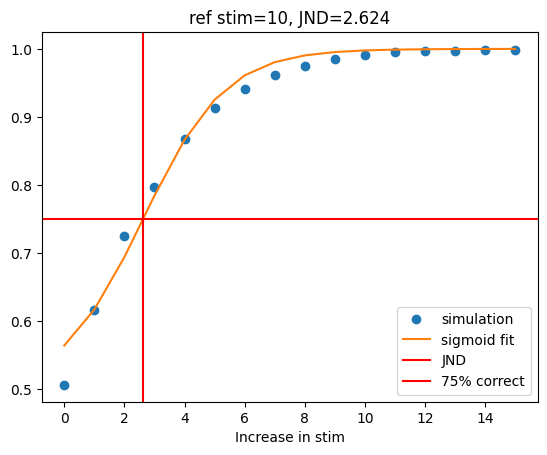

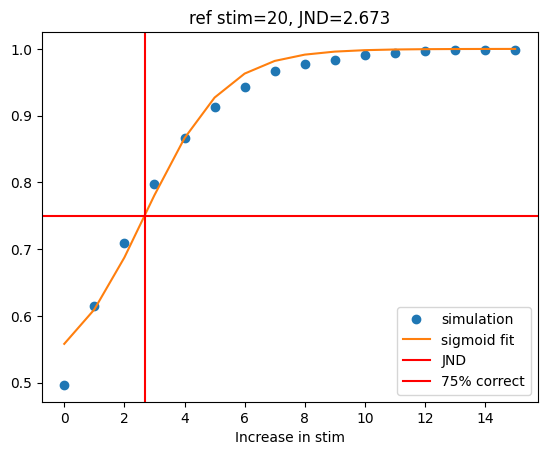

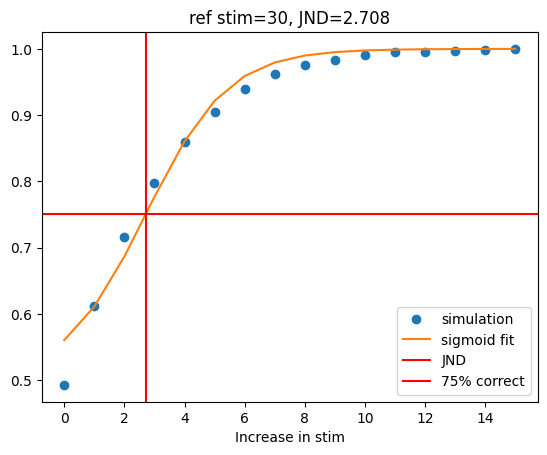

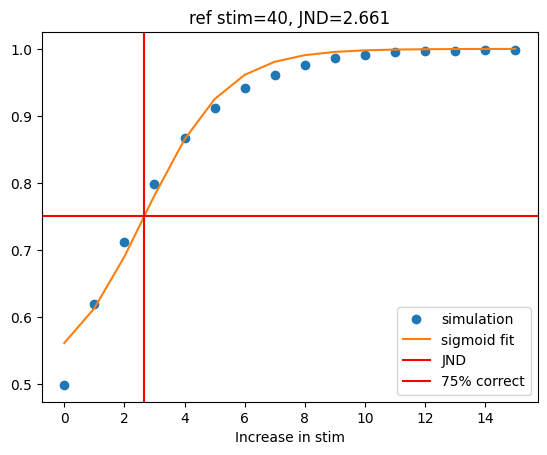

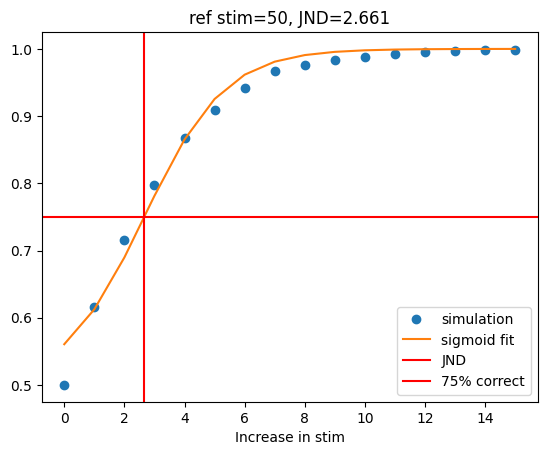

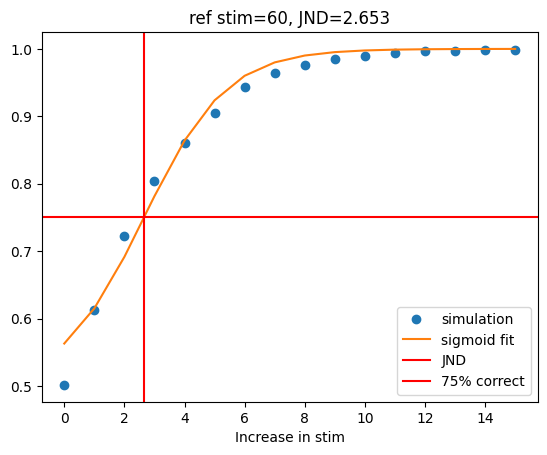

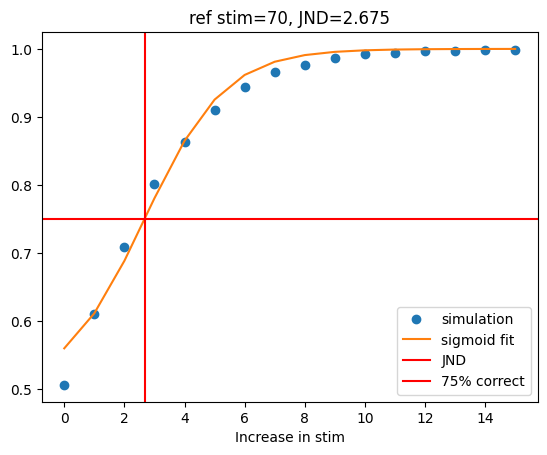

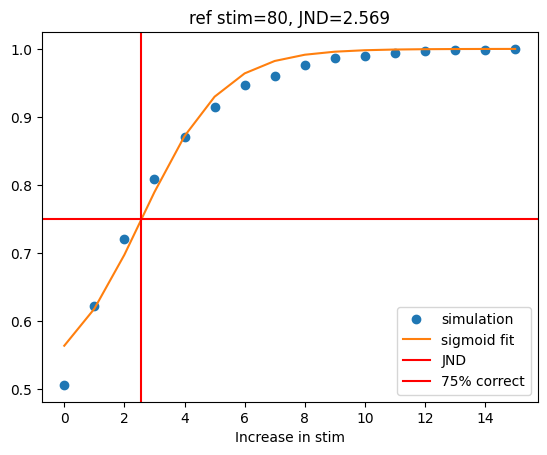

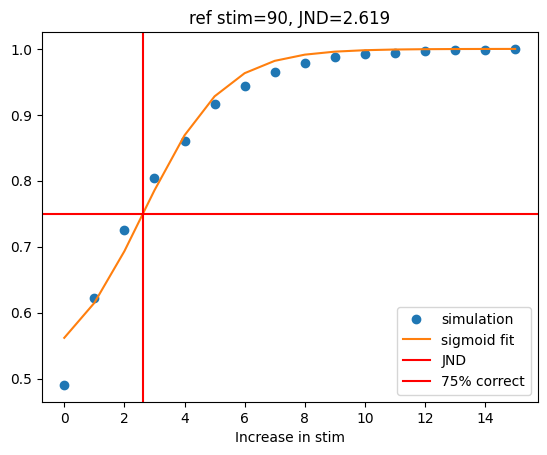

In [6]:
N_sim = int(10e3)

ref_sounds = np.arange(10, 100, 10) # sound in the left speaker that serve as ref stimulus
JND_ref_sounds = np.zeros_like(ref_sounds)  
for idx, ref in enumerate(ref_sounds):
    inc_stim_vals = np.arange(0, 16, 1)
    acc_for_ref = []
    for inc_stim in inc_stim_vals:
        sound_1 = ref
        sound_2 = ref + inc_stim
        ABL = (sound_1 + sound_2) * 0.5
        ILD = sound_2 - sound_1
        sim_results = Parallel(n_jobs=24)(delayed(tied_data_gen_wrapper)([ILD], [ABL], _lambda, theta_E, T_0, 0, 1e-3) for _ in range(N_sim))
        num_choice_corr = np.sum([1 for res in sim_results if res['choice'] == 1])
        frac_correct = num_choice_corr / N_sim
        acc_for_ref.append(frac_correct)
    
    popt, _ = curve_fit(psychometric, inc_stim_vals, acc_for_ref, p0=[1,1])
    alpha, _ = popt
    JND_ref_sounds[idx] = alpha

    plt.plot(inc_stim_vals, acc_for_ref, 'o', label='simulation')
    plt.plot(inc_stim_vals, psychometric(inc_stim_vals, *popt), '-', label='sigmoid fit')
    plt.axvline(alpha, color='r', label='JND')
    plt.axhline(0.75, color='r', label='75% correct')
    plt.xlabel('Increase in stim')
    plt.title(f'ref stim={ref}, JND={alpha:.3f}')
    plt.legend()
    plt.show();




# JND vs ref stimulus - straight line confirming weber law

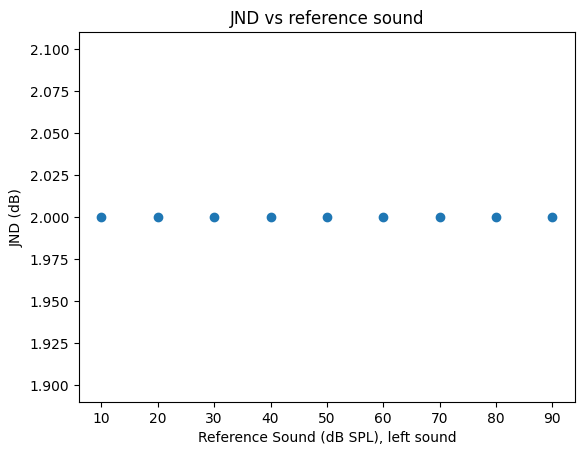

In [7]:
plt.plot(ref_sounds, JND_ref_sounds, 'o')
plt.xlabel('Reference Sound (dB SPL), left sound')
plt.ylabel('JND (dB)')
plt.title('JND vs reference sound');